In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import time
import pickle

%matplotlib inline

# Load Original Features

In [2]:
feat_num = 438

In [3]:
#df_total_raw = pd.read_csv('./data/features%s.csv'%(feat_num))
with open('./data/features%s.pickle'%(feat_num), 'rb') as handle:
    df_total_raw = pickle.load(handle)

In [4]:
#to_drop = ['card1_count','addr2','V117','V118','V120','V122','id_25','id_21','id_26',
#           'V305','id_17','V27','V28','V88','V89','id_14','V107','V240','V241','V41','id_24','V68']
#to_drop = ['TransactionDT']
#to_drop = ['V'+str(i) for i in range(1,340)]
with open('./data/feat%s_rm_pm_importance100.pickle'%(437), 'rb') as handle:
    to_drop = pickle.load(handle)

In [5]:
df_total = df_total_raw.drop(to_drop,axis=1)
#df_total = df_total_raw

In [6]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [7]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [8]:
features_train.shape

(590540, 336)

# Prepare model

In [9]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version',
              'is_card_freq_Device','is_wide','is_long','is_zero','is_win8_vista',
              'is_windows_otheros','is_card_freq_pdc','is_card_freq_addr1'] 
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [10]:
categorical = list(set(categorical).intersection(df_total.columns))

In [11]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [12]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type":"gbdt",#'goss'
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
          #'num_threads':10
          #'device' :'gpu',
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Feature Selection

In [13]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_36,id_38,DeviceType,DeviceInfo,P_email,R_email,screen_width,pdc_amt_ratio,card1_fq_enc,addr1_fq_enc
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,-1,-1,-1,-1,-1,-1,-1,0.445929,56,43035.0
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,-1,-1,-1,-1,0,-1,-1,0.188788,1338,76902.0
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,-1,-1,-1,-1,1,-1,-1,0.384085,1794,48387.0
3,86499,50.0,0,18132,567.0,150.0,1,117.0,1,476.0,...,-1,-1,-1,-1,2,-1,-1,0.325496,7635,17455.0
4,86506,50.0,1,4497,514.0,150.0,1,102.0,0,420.0,...,0,0,0,0,0,-1,0,0.686003,30,7107.0


In [50]:
start = time.time()
train_set = lgb.Dataset(features_train.iloc[0:472432,:], label=labels_train.values[0:472432],categorical_feature=categorical)#
valid_set = lgb.Dataset(features_train.iloc[472432:,:], label=labels_train.values[472432:],categorical_feature=categorical)#
valid_results = {}
model = lgb.train(params,train_set,num_boost_round = 10000, 
                  valid_sets = [train_set, valid_set],
                  verbose_eval=500,
                  early_stopping_rounds = 500,
                  evals_result=valid_results)
print(time.time()-start)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987454	valid_1's auc: 0.918283
[1000]	training's auc: 0.998211	valid_1's auc: 0.925361
[1500]	training's auc: 0.999837	valid_1's auc: 0.925991
[2000]	training's auc: 0.999991	valid_1's auc: 0.926378
[2500]	training's auc: 1	valid_1's auc: 0.926884
[3000]	training's auc: 1	valid_1's auc: 0.927029
[3500]	training's auc: 1	valid_1's auc: 0.92707
Early stopping, best iteration is:
[3271]	training's auc: 1	valid_1's auc: 0.927147
526.1498918533325


In [51]:
max(valid_results['valid_1']['auc'])

0.9271473619830942

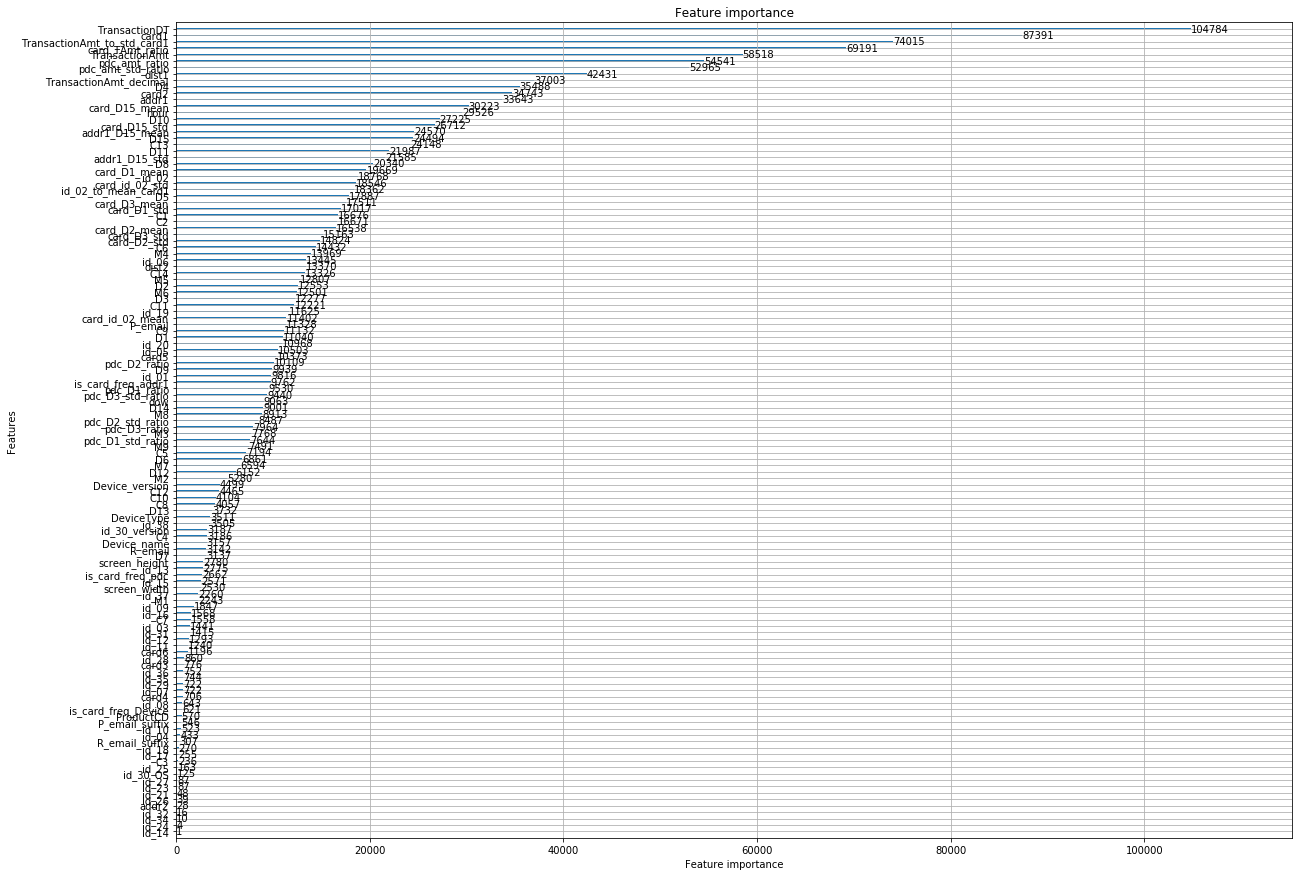

In [57]:
lgb.plot_importance(model, max_num_features=128,figsize=(20,15))

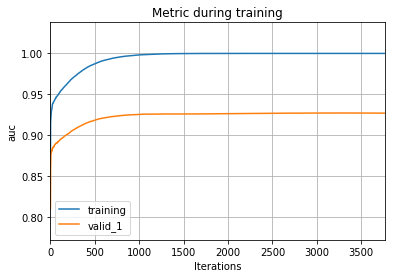

In [58]:
#lgb.plot_split_value_histogram(model, feature='dist1', bins='auto')
lgb.plot_metric(valid_results, metric='auc')

In [ ]:
lgb.plot_tree(model,tree_index=0, figsize=(107,105))

In [29]:
graph = lgb.create_tree_digraph(model, tree_index=0, name='Tree0')
graph.render(view=True)

'Tree0.gv.pdf'

# Train Model

In [15]:
splits = 5
folds = KFold(n_splits = splits,random_state=50)
predictions = np.zeros(len(features_test_new))
ave_auc = 0

In [16]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    valid_results = {}
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500,
                   evals_result=valid_results)
    
    pred = clf.predict(valid_df)
    auc_score = roc_auc_score(y_valid_df, pred)
    ave_auc += auc_score / splits
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986483	valid_1's auc: 0.91073
[1000]	training's auc: 0.997376	valid_1's auc: 0.921659
[1500]	training's auc: 0.999546	valid_1's auc: 0.923766
[2000]	training's auc: 0.99993	valid_1's auc: 0.92472
[2500]	training's auc: 0.999992	valid_1's auc: 0.924817
[3000]	training's auc: 0.999999	valid_1's auc: 0.925132
[3500]	training's auc: 1	valid_1's auc: 0.925078
Early stopping, best iteration is:
[3037]	training's auc: 1	valid_1's auc: 0.925155
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.98701	valid_1's auc: 0.932035
[1000]	training's auc: 0.997805	valid_1's auc: 0.939178
[1500]	training's auc: 0.999672	valid_1's auc: 0.939397
Early stopping, best iteration is:
[1299]	training's auc: 0.999276	valid_1's auc: 0.939786
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987873	valid_1's auc: 0.931763
[1000]	training's auc: 0.997929	valid_1's auc: 0.937332
[1500]	training's auc: 0.999673	valid_1's auc: 0.936946
Early stopping, best iteration is:
[1076]	training's auc: 0.998421	valid_1's auc: 0.937433
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.9871	valid_1's auc: 0.947032
[1000]	training's auc: 0.997844	valid_1's auc: 0.954262
[1500]	training's auc: 0.99969	valid_1's auc: 0.954746
Early stopping, best iteration is:
[1329]	training's auc: 0.999383	valid_1's auc: 0.954877
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.986808	valid_1's auc: 0.923813
[1000]	training's auc: 0.997729	valid_1's auc: 0.931203
[1500]	training's auc: 0.999638	valid_1's auc: 0.931681
Early stopping, best iteration is:
[1303]	training's auc: 0.99925	valid_1's auc: 0.931777


In [17]:
# feat438 add addr1 cnt drop feat437_rm_pm_importance100
ave_auc

0.9378057475398072

In [34]:
# feat437 add card1 cnt drop feat437_rm_pm_importance100
ave_auc

0.9372995256863785

In [17]:
# feat437 add card1 cnt drop transactionDT
ave_auc

0.9347757078114228

In [68]:
# feat437 add card1 cnt
ave_auc

0.9371691266159269

In [33]:
# feat436 add pdc amt ratio
ave_auc

0.9360835858343227

In [15]:
# feat469 drop addtional feature 
ave_auc

0.9334089405096319

In [72]:
# feat469new
ave_auc

0.9352356215532373

In [34]:
# feat457new
ave_auc

0.9355565773520604

In [16]:
# feat469 drop addtional feature
ave_auc

0.9321073147992665

In [62]:
# # feat469 drop Vfeature
ave_auc

0.9319730729043392

In [31]:
# feat457 drop Vfeature
ave_auc

0.9320555176749314

In [16]:
# feat 457 drop c8
ave_auc

0.9354828335082059

In [19]:
# feat 457 all features
ave_auc

0.9352800271384787

In [44]:
###### drop using feat476_rm_pm_importance0
ave_auc

0.9352034490404105

In [18]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_drop100.csv'%(feat_num), index = False)
